### Constants

In [1]:
model_name = "BAAI/bge-base-en-v1.5"
custom_model_name = "julep-ai/dialog-bge-base"
max_len = 512
combined_path = "./data/combined"

### Imports and utils

In [2]:
%matplotlib inline

from functools import partial
import itertools as it
import os
import random

from datasets import load_from_disk
from FlagEmbedding import FlagModel
import jsonlines as jsonl
from lion_pytorch import Lion
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sentence_transformers import InputExample, SentenceTransformer, losses as ls, models as ml, util
from sentence_transformers.evaluation import SimilarityFunction, TripletEvaluator
import torch
from torch.utils.data import DataLoader, IterableDataset
from tqdm.auto import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

### Datasets

- combined: stacked_samsum + dialogsum
- hn_output: hard negatives mined triple set

In [3]:
combined = load_from_disk("./data/combined")

### Embed using base model (before tuning)

In [4]:
def embed(rows, model_name=model_name, wrap_items=False):
    from sentence_transformers import SentenceTransformer

    model = SentenceTransformer(model_name)
    
    dialogues = rows["dialogue"]
    summaries = rows["summary"]

    if wrap_items:
        dialogues = [dict(dialog=dialogue) for dialogue in dialogues]
        summaries = [dict(fact=summary) for summary in summaries]

    dialogue_embs = model.encode(dialogues).tolist()
    summary_embs = model.encode(summaries).tolist()

    return dict(
        dialogue_emb=dialogue_embs,
        summary_emb=summary_embs,
    )

In [5]:
base_eval_ds = combined["test"].map(embed, batch_size=500, batched=True)

Map:   0%|          | 0/13968 [00:00<?, ? examples/s]

In [6]:
def calc_cos_sim(row):
    dialogue_emb = row["dialogue_emb"]
    summary_emb = row["summary_emb"]

    a = np.array(dialogue_emb)
    b = np.array(summary_emb)

    cos_sim = dot(a, b)/(norm(a)*norm(b))

    return dict(similarity=cos_sim)

In [7]:
base_eval_ds = base_eval_ds.map(calc_cos_sim, num_proc=40)

Map (num_proc=40):   0%|          | 0/13968 [00:00<?, ? examples/s]

### Evaluation (before tuning)

1

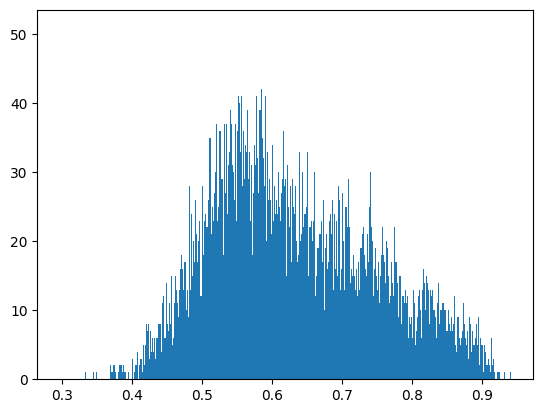

In [8]:
plt.hist(base_eval_ds["similarity"], bins=1000); 1

### Evaluation (after tuning)

In [9]:
custom_embed = partial(embed, model_name=custom_model_name, wrap_items=True)
custom_eval_ds = combined["test"].map(custom_embed, batched=True, batch_size=500)

Map:   0%|          | 0/13968 [00:00<?, ? examples/s]

In [10]:
custom_eval_ds = custom_eval_ds.map(calc_cos_sim, num_proc=40)

Map (num_proc=40):   0%|          | 0/13968 [00:00<?, ? examples/s]

1

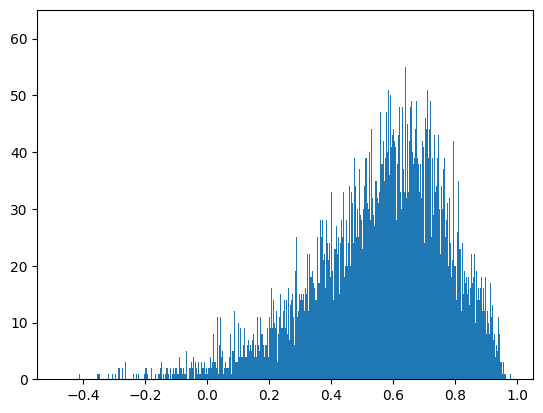

In [11]:
plt.hist(custom_eval_ds["similarity"], bins=1000); 1